In [14]:
!pip install arch yfinance > log.txt

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from datetime import timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [84]:
def get_hourly_data(name='BTC', start='2023-10-01', end='2024-12-01'):
    data = yf.download(f'{name}-USD', start=start, end=end, interval='1h')
    data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()
    data['Log Returns'] = (np.log(data['Adj Close'])).diff()
    return data

def generate_HAR_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HAR модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(volatility.index),
        'rv': volatility.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    return rv_data

def generate_HARQ_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HARQ модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    rq = new_data['Log Returns'].resample('D').apply(lambda x: np.sum(x**4))
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(rq.index),
        'rv': volatility.values,
        'rq': rq.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    rv_data['rq w'] = rv_data['rq'].rolling(window=w_len).mean()
    rv_data['rq m'] = rv_data['rq'].rolling(window=m_len).mean()

    return rv_data

def generate_HARJ_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HARJ (с д jump) модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    daily_returns = new_data['Log Returns'].resample('D').mean()
    bpv = new_data['Log Returns'].resample('D').apply(lambda x: np.sum(np.abs(x[1:]) * np.abs(x[:-1])))
    jump = np.maximum(volatility.values - bpv.values, 0)

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(volatility.index),
        'rv': volatility.values,
        'daily returns': daily_returns.values,
        'bpv': bpv,
        'jump': jump
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    return rv_data

In [85]:
class HAR:
  def __init__(self, name='HAR'):
    self.name = name

  def __fit_har(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv m'][:-1]
    })
    self.X = X

  def __fit_harq(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv w'][:-1],
      'RQ': np.sqrt(data['rq'][:-1]) * data['rv'][:-1],
      'RQ_w': np.sqrt(data['rq w'][:-1]) * data['rv w'][:-1],
      'RQ_m': np.sqrt(data['rq m'][:-1]) * data['rv m'][:-1],
    })
    self.X = X

  def __fit_harj(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv w'][:-1],
      'J': data['jump'][:-1]
    })
    self.X = X

  def fit(self, data):
    if self.name == 'HAR':
        self.__fit_har(data)
    elif self.name == 'HARQ':
        self.__fit_harq(data)
    elif self.name == 'HAR-J':
        self.__fit_harj(data)

    X = self.X.reset_index(drop=True)
    X = sm.add_constant(X)
    y = data['rv'][1:]
    y = y.reset_index(drop=True)
    model = sm.OLS(y, X).fit()
    self.model = model

  def predict(self, data):

    last_row = 0
    if self.name == 'HAR':
      last_row = data[['rv', 'rv w', 'rv m']].iloc[-1]
    elif self.name == 'HARQ':
      last_row = data[['rv', 'rv w', 'rv m', 'rq', 'rq w', 'rq m']].iloc[-1]
    elif self.name == 'HAR-J':
      last_row = data[['rv', 'rv w', 'rv m', 'jump']].iloc[-1]

    last_row_with_const = [1] + last_row.tolist()
    last_row_with_const = np.array(last_row_with_const).reshape(1, -1)
    predictions = self.model.predict(last_row_with_const)

    return predictions

def get_rolling_har_predictions(data, model_name='HAR', window_size=100):
    vol_forecast = []

    for i in range(window_size, len(data)):
        window_data = data[i - window_size : i]
        model = HAR(name=model_name)
        model.fit(window_data)
        vol_forecast.append(model.predict(window_data))

    return np.array(vol_forecast).flatten()

def get_naive_predictions(data, window=100):
    return np.array(data['rv'][window:]).flatten()

In [86]:
hourly_data = get_hourly_data()
har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()
har_data.head(5)

[*********************100%***********************]  1 of 1 completed


,Datetime,rv,daily returns,rv w,rv m
29,2023-10-30 00:00:00+00:00,0.002667,-0.000037,0.004091,0.003689
30,2023-10-31 00:00:00+00:00,0.003250,0.000196,0.003285,0.003596
31,2023-11-01 00:00:00+00:00,0.006307,0.000917,0.003514,0.003635
32,2023-11-02 00:00:00+00:00,0.004080,-0.000592,0.003566,0.003670
33,2023-11-03 00:00:00+00:00,0.004826,-0.000247,0.003689,0.003757


In [87]:
har_predictions = get_rolling_har_predictions(har_data, model_name='HAR')
naive_predictions = get_naive_predictions(har_data)

In [88]:
def cut_data(data, predictions):
  """
  Функция обрезает данных из даты и predictions по одинаквым периодам, что бы можно было построить график или посчитать метрики
  """
  cut_predictions = predictions[:-1]
  predictions_size = len(cut_predictions)
  cut_realize_volatility = data['rv'][-predictions_size:]
  cut_datetime_axes = data['Datetime'][-predictions_size:]
  return cut_predictions, cut_realize_volatility, cut_datetime_axes

def plot_predictions(data, predictions):
  cut_predictions, cut_realize_volatility, cut_datetime_axes = cut_data(data, predictions)

  plt.figure(figsize=(12, 6))

  plt.plot(cut_datetime_axes, cut_realize_volatility, label='Realized Volatility', color='blue')
  plt.plot(cut_datetime_axes, cut_predictions, label='Predicted Volatility', color='red')
  plt.title('Predicted vs. Realized Volatility')
  plt.xlabel('Date')
  plt.ylabel('Volatility (%)')
  plt.legend()
  plt.grid()
  plt.show()

def calculate_metrics(data, predictions):
  cut_predictions, cut_realize_volatility, _ = cut_data(data, predictions)
  return {
      'MSE': ((cut_realize_volatility - cut_predictions).dropna()**2).mean(),
      'MAE': np.abs(cut_realize_volatility - cut_predictions).dropna().mean()
  }

HAR {'MSE': 7.09925787619516e-06, 'MAE': 0.001922176447482286}
naive {'MSE': 8.163568272691078e-06, 'MAE': 0.0021528144320969484}


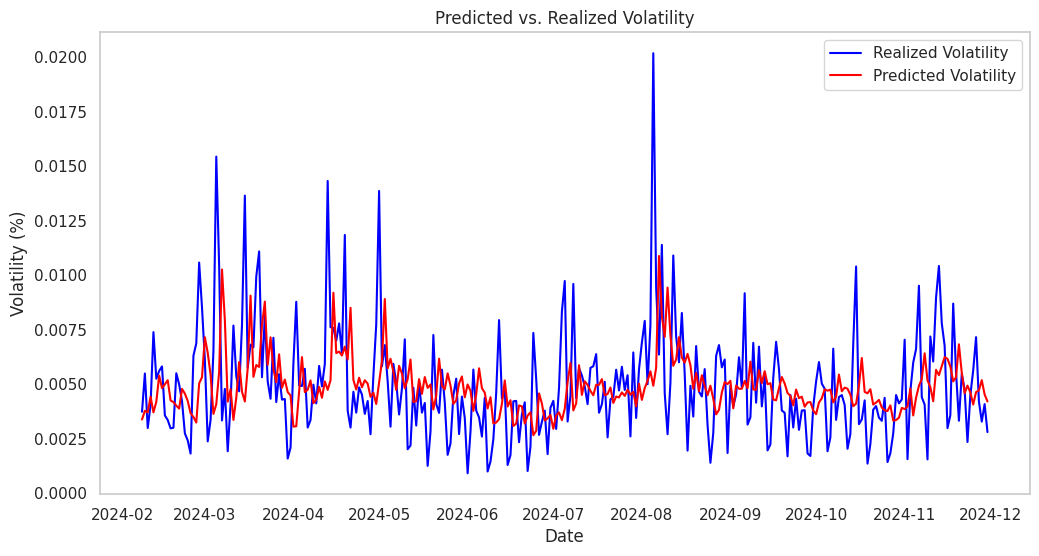

In [89]:
print('HAR', calculate_metrics(har_data, har_predictions))
print('naive', calculate_metrics(har_data, naive_predictions))

plot_predictions(har_data, har_predictions)

# HARQ

In [90]:
harq_data = generate_HARQ_data(hourly_data, w_len=5, m_len=22)
harq_data = harq_data.dropna()

harq_predictions = get_rolling_har_predictions(harq_data, model_name='HARQ')

harq_data.head(5)

,Datetime,rv,rq,daily returns,rv w,rv m,rq w,rq m
21,2023-10-22 00:00:00+00:00,0.003131,1.135618e-08,0.000097,0.003460,0.003237,3.448713e-08,6.614932e-08
22,2023-10-23 00:00:00+00:00,0.010815,5.552195e-06,0.004057,0.005050,0.003454,1.143814e-06,2.880660e-07
23,2023-10-24 00:00:00+00:00,0.008893,3.628005e-07,0.001079,0.006311,0.003625,1.215534e-06,3.017242e-07
24,2023-10-25 00:00:00+00:00,0.004702,2.446099e-08,0.000744,0.006150,0.003701,1.192237e-06,3.026180e-07
25,2023-10-26 00:00:00+00:00,0.003719,8.396727e-09,-0.000411,0.006252,0.003770,1.191842e-06,3.029373e-07


HARQ: {'MSE': 8.140129831594e-06, 'MAE': 0.002073662451658865}
naive: {'MSE': 8.163568272691078e-06, 'MAE': 0.0021528144320969484}


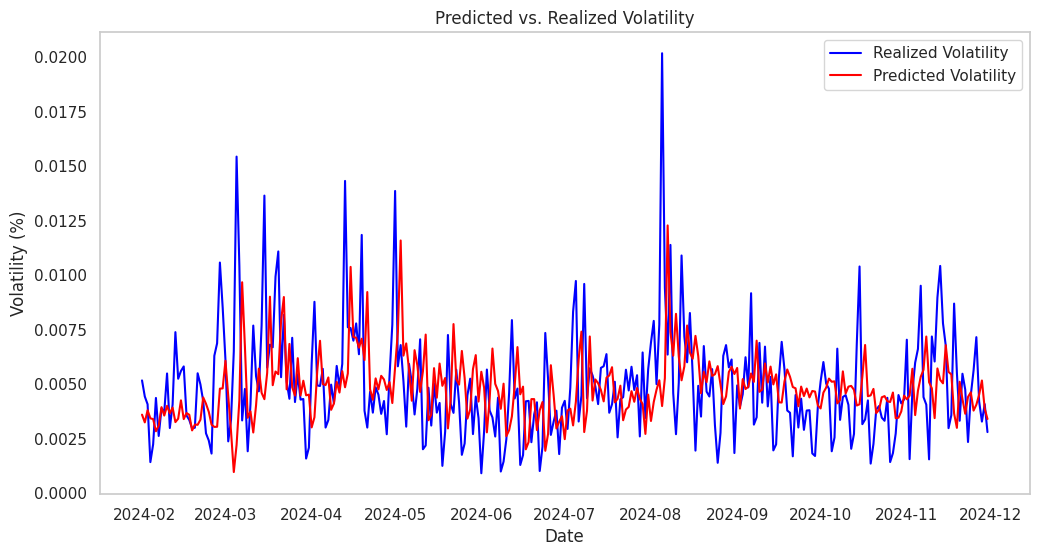

In [91]:
print('HARQ:', calculate_metrics(harq_data, harq_predictions))
print('naive:', calculate_metrics(har_data, naive_predictions))

plot_predictions(harq_data, harq_predictions)

# HAR with JUMP

In [92]:
harj_data = generate_HARJ_data(hourly_data, w_len=5, m_len=22)
harj_data = harj_data.dropna()
harj_data.head(15)

,Datetime,rv,daily returns,bpv,jump,rv w,rv m
Datetime,,,,,,,
2023-10-22 00:00:00+00:00,2023-10-22 00:00:00+00:00,0.003131,0.000097,0.000218,0.002913,0.003460,0.003237
2023-10-23 00:00:00+00:00,2023-10-23 00:00:00+00:00,0.010815,0.004057,0.003038,0.007777,0.005050,0.003454
2023-10-24 00:00:00+00:00,2023-10-24 00:00:00+00:00,0.008893,0.001079,0.001406,0.007487,0.006311,0.003625
2023-10-25 00:00:00+00:00,2023-10-25 00:00:00+00:00,0.004702,0.000744,0.000491,0.004211,0.006150,0.003701
2023-10-26 00:00:00+00:00,2023-10-26 00:00:00+00:00,0.003719,-0.000411,0.000298,0.003421,0.006252,0.003770
2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,0.003963,-0.000303,0.000347,0.003616,0.006418,0.003754
2023-10-28 00:00:00+00:00,2023-10-28 00:00:00+00:00,0.002035,0.000222,0.000096,0.001939,0.004662,0.003629
2023-10-29 00:00:00+00:00,2023-10-29 00:00:00+00:00,0.002661,0.000542,0.000144,0.002518,0.003416,0.003695
2023-10-30 00:00:00+00:00,2023-10-30 00:00:00+00:00,0.002667,-0.000037,0.000160,0.002507,0.003009,0.003749


HAR: {'MSE': 7.09925787619516e-06, 'MAE': 0.001922176447482286}
HAR-J: {'MSE': 8.275913637284315e-06, 'MAE': 0.002263349091534266}
naive: {'MSE': 8.163568272691078e-06, 'MAE': 0.0021528144320969484}


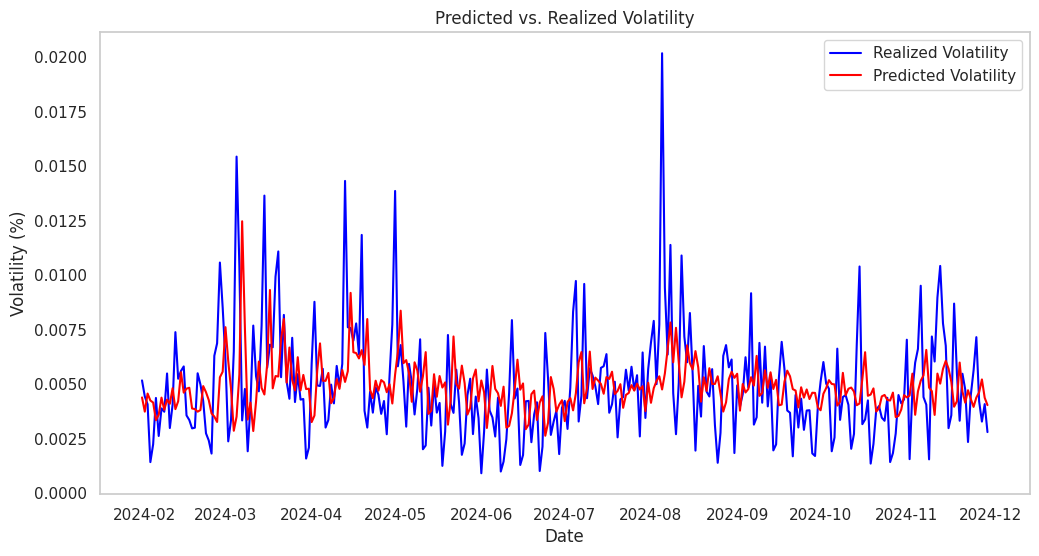

In [93]:
print('HAR:', calculate_metrics(har_data, har_predictions))
print('HAR-J:', calculate_metrics(harj_data, harj_predictions))
print('naive:', calculate_metrics(harj_data, naive_predictions))

harj_predictions = get_rolling_har_predictions(harj_data, model_name='HAR-J')
plot_predictions(harj_data, harj_predictions)

# GARCH

In [94]:
def get_rolling_garch_predictions(returns, model_params, window_size=100):
    vol_forecast = []
    mul_returns = returns * 1000
    for i in range(window_size, len(mul_returns)):
        window_data = mul_returns[i-window_size:i]
        model = arch_model(window_data, **model_params)
        garch_fit = model.fit(disp="off", options={'maxiter': 350})
        # Forecast one-step ahead volatility
        vol_forecast.append(garch_fit.forecast(horizon=1).variance.values[-1, :][0])

    # Align the forecast with the returns data
    vol_forecast = pd.Series(vol_forecast, index=returns.index[window_size:])
    # return vol_forecast
    return np.sqrt(vol_forecast * 24) / 1000

In [95]:
model_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o': 1}
garch_predictions = get_rolling_garch_predictions(har_data['daily returns'], model_params)

HAR: {'MSE': 7.09925787619516e-06, 'MAE': 0.001922176447482286}
naive: {'MSE': 8.163568272691078e-06, 'MAE': 0.0021528144320969484}
GARCH: {'MSE': 7.762164640461113e-06, 'MAE': 0.002110975885314892}


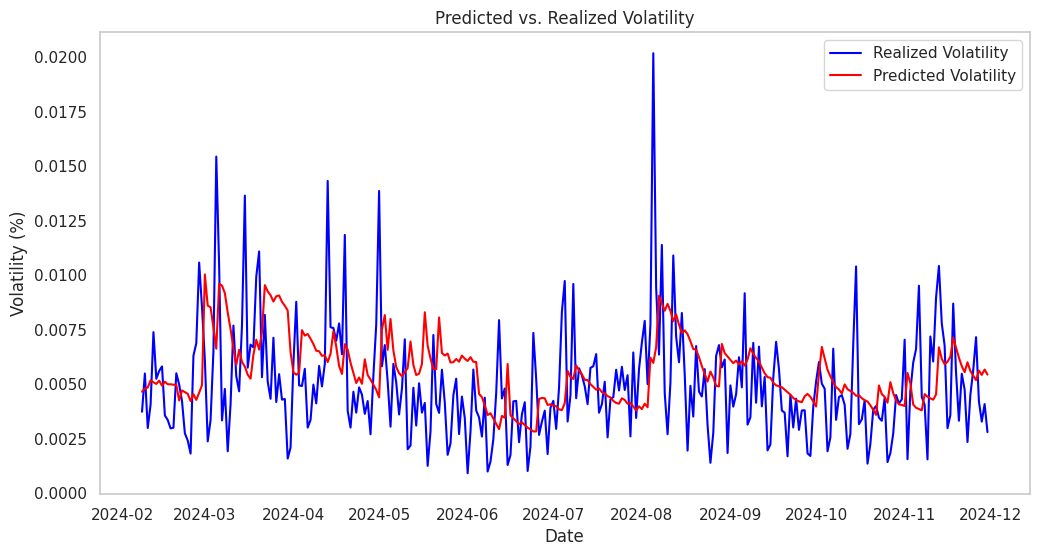

In [96]:
print('HAR:', calculate_metrics(har_data, har_predictions))
print('naive:', calculate_metrics(har_data, naive_predictions))
print('GARCH:', calculate_metrics(har_data, garch_predictions.values))

plot_predictions(har_data, garch_predictions.values)

In [97]:
print('naive:', calculate_metrics(har_data, naive_predictions))
print('HAR:',   calculate_metrics(har_data, har_predictions))
print('HARQ:',  calculate_metrics(harq_data, harq_predictions))
print('HAR-J:', calculate_metrics(harj_data, harj_predictions))
print('GARCH:', calculate_metrics(har_data, garch_predictions.values))

naive: {'MSE': 8.163568272691078e-06, 'MAE': 0.0021528144320969484}
HAR: {'MSE': 7.09925787619516e-06, 'MAE': 0.001922176447482286}
HARQ: {'MSE': 8.140129831594e-06, 'MAE': 0.002073662451658865}
HAR-J: {'MSE': 7.2254676744555495e-06, 'MAE': 0.0019353091894034591}
GARCH: {'MSE': 7.762164640461113e-06, 'MAE': 0.002110975885314892}


In [98]:
naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)

table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']]
]


def plot_table(data):
    table = pd.DataFrame(data, columns=["Model", "MSE", "MAE"])
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid")
    styled_table = table.style.background_gradient(cmap="Oranges")#, subset=['MSSE', 'MASE'])
    styled_table = styled_table.set_properties(**{'text-align': 'center'})
    display(styled_table)

plot_table(table_data)

,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.149919,1.119988
2,HARQ,1.002879,1.038170
3,HAR-J,1.129833,1.112388
4,GARCH,1.051713,1.019820


<Figure size 800x400 with 0 Axes>

# Ансамбль моделей

In [99]:
class HAR_GARCH_ensemble:
  def __init__(self, har_params, garch_params, naive_add=False):
    self.har_params = har_params
    self.garch_params = garch_params
    self.naive_add = naive_add

  def fit_predict(self, data):
    garch_predictions = get_rolling_garch_predictions(data['daily returns'], self.garch_params)
    har_predictions = get_rolling_har_predictions(har_data, model_name=self.har_params)

    if self.naive_add:
      weight = 1.0/3
      naive_predictions = get_naive_predictions(har_data)
      return garch_predictions.values * weight + har_predictions * weight + naive_predictions * weight

    return garch_predictions.values * 0.5 + har_predictions * 0.5


In [100]:
har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()

garch_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o': 1}

har_garch_ensemble = HAR_GARCH_ensemble(
  har_params='HAR',
  garch_params=garch_params
)

har_garch_naive_ensemble = HAR_GARCH_ensemble(
  har_params='HAR',
  garch_params=garch_params,
  naive_add = True
)

ensemble_har_garch_predictions = har_garch_ensemble.fit_predict(har_data)
ensemble_har_garch_naive_predictions = har_garch_naive_ensemble.fit_predict(har_data)

# plot_predictions(har_data, ansamble_har_garch_predictions)

In [101]:
naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)
ensemble_har_garch_metrics = calculate_metrics(har_data, ensemble_har_garch_predictions)
ensemble_har_garch_naive_metrics = calculate_metrics(har_data, ensemble_har_garch_naive_predictions)
table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']],
    ['HAR-GARCH', naive_metrics['MSE'] / ensemble_har_garch_metrics['MSE'], naive_metrics['MAE'] / ensemble_har_garch_metrics['MAE']],
    ['HAR-GARCH-NAIVE', naive_metrics['MSE'] / ensemble_har_garch_naive_metrics['MSE'], naive_metrics['MAE'] / ensemble_har_garch_naive_metrics['MAE']],

]

plot_table(table_data)

,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.149919,1.119988
2,HARQ,1.002879,1.038170
3,HAR-J,1.129833,1.112388
4,GARCH,1.051713,1.019820
5,HAR-GARCH,1.165875,1.103350
6,HAR-GARCH-NAIVE,1.338017,1.179550


<Figure size 800x400 with 0 Axes>

# ETH

In [102]:
hourly_data = get_hourly_data(name='ETH')

har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()
har_predictions = get_rolling_har_predictions(har_data, model_name='HAR')

naive_predictions = get_naive_predictions(har_data)

harq_data = generate_HARQ_data(hourly_data, w_len=5, m_len=22)
harq_data = harq_data.dropna()
harq_predictions = get_rolling_har_predictions(harq_data, model_name='HARQ')

harj_data = generate_HARJ_data(hourly_data, w_len=5, m_len=22)
harj_data = harj_data.dropna()
harj_predictions = get_rolling_har_predictions(harj_data, model_name='HAR-J')

model_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o' : 1}
garch_predictions = get_rolling_garch_predictions(har_data['daily returns'], model_params)

naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)

table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']]
]

plot_table(table_data)

[*********************100%***********************]  1 of 1 completed


,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.203817,1.144478
2,HARQ,1.196867,1.107957
3,HAR-J,1.249499,1.170907
4,GARCH,0.656430,0.856291


<Figure size 800x400 with 0 Axes>

In [103]:
har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()

garch_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o': 1}

har_garch_ensemble = HAR_GARCH_ensemble(
  har_params='HAR',
  garch_params=garch_params
)

har_garch_naive_ensemble = HAR_GARCH_ensemble(
  har_params='HAR',
  garch_params=garch_params,
  naive_add = True
)

ensemble_har_garch_predictions = har_garch_ensemble.fit_predict(har_data)
ensemble_har_garch_naive_predictions = har_garch_naive_ensemble.fit_predict(har_data)

naive_metrics = calculate_metrics(har_data, naive_predictions)
har_metrics   = calculate_metrics(har_data, har_predictions)
harq_metrics  = calculate_metrics(harq_data, harq_predictions)
harj_metrics  = calculate_metrics(harj_data, harj_predictions)
garch_metrics = calculate_metrics(har_data, garch_predictions.values)
ensemble_har_garch_metrics = calculate_metrics(har_data, ensemble_har_garch_predictions)
ensemble_har_garch_naive_metrics = calculate_metrics(har_data, ensemble_har_garch_naive_predictions)
table_data = [
    ['naive', naive_metrics['MSE'] / naive_metrics['MSE'], naive_metrics['MAE'] / naive_metrics['MAE']],
    ['HAR',   naive_metrics['MSE'] / har_metrics  ['MSE'], naive_metrics['MAE'] / har_metrics  ['MAE']],
    ['HARQ',  naive_metrics['MSE'] / harq_metrics ['MSE'], naive_metrics['MAE'] / harq_metrics ['MAE']],
    ['HAR-J', naive_metrics['MSE'] / harj_metrics ['MSE'], naive_metrics['MAE'] / harj_metrics ['MAE']],
    ['GARCH', naive_metrics['MSE'] / garch_metrics['MSE'], naive_metrics['MAE'] / garch_metrics['MAE']],
    ['HAR-GARCH', naive_metrics['MSE'] / ensemble_har_garch_metrics['MSE'], naive_metrics['MAE'] / ensemble_har_garch_metrics['MAE']],
    ['HAR-GARCH-NAIVE', naive_metrics['MSE'] / ensemble_har_garch_naive_metrics['MSE'], naive_metrics['MAE'] / ensemble_har_garch_naive_metrics['MAE']],

]

plot_table(table_data)

,Model,MSE,MAE
0,naive,1.000000,1.000000
1,HAR,1.203817,1.144478
2,HARQ,1.196867,1.107957
3,HAR-J,1.249499,1.170907
4,GARCH,0.656430,0.856291
5,HAR-GARCH,1.023328,1.024813
6,HAR-GARCH-NAIVE,1.194708,1.108343


<Figure size 800x400 with 0 Axes>